In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=1)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR053' 

In [6]:
WuLEVEL = 1
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-9.28471493e-03 -2.21597483e+06]
Y_MAX [8.97879311e-03 2.21630009e+06]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 101250000.0, 0, 0.2]
X_MAX [1, 167500000.0, 7.4, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

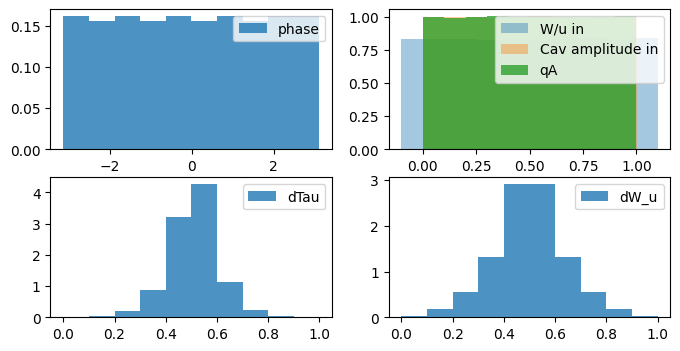

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=1))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 32, 64, 32],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-02-29 18:04
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 5000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL1/model.pt
  - fname_opt: ./WuLEVEL1/optimizer.pt
  - fname_history: ./WuLEVEL1/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:1
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:1
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:1
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:1
 

 Epoch 0067: | Train Loss: 1.91E-07 | Val Loss: 2.66E-07 | lr: 2.50E-05 | 0:33:50.273377
 Epoch 0068: | Train Loss: 1.91E-07 | Val Loss: 1.66E-07 | lr: 2.55E-05 | 0:34:22.448701
 Epoch 0069: | Train Loss: 1.91E-07 | Val Loss: 4.16E-07 | lr: 2.59E-05 | 0:34:48.827184
 Epoch 0070: | Train Loss: 1.92E-07 | Val Loss: 1.53E-07 | lr: 2.63E-05 | 0:35:25.482374
 Epoch 0071: | Train Loss: 1.93E-07 | Val Loss: 1.61E-07 | lr: 2.68E-05 | 0:35:52.083034
 Epoch 0072: | Train Loss: 1.93E-07 | Val Loss: 1.42E-07 | lr: 2.72E-05 | 0:36:19.311780
 Epoch 0073: | Train Loss: 1.94E-07 | Val Loss: 1.68E-07 | lr: 2.76E-05 | 0:36:45.568052
 Epoch 0074: | Train Loss: 1.95E-07 | Val Loss: 2.77E-07 | lr: 2.81E-05 | 0:37:12.366250
 Epoch 0075: | Train Loss: 1.97E-07 | Val Loss: 4.89E-07 | lr: 2.85E-05 | 0:37:39.116333
 Epoch 0076: | Train Loss: 1.98E-07 | Val Loss: 1.70E-07 | lr: 2.90E-05 | 0:38:07.578197
 Epoch 0077: | Train Loss: 2.00E-07 | Val Loss: 2.41E-07 | lr: 2.95E-05 | 0:38:41.065101
 Epoch 0078: | Train 

 Epoch 0160: | Train Loss: 5.41E-07 | Val Loss: 1.18E-06 | lr: 7.42E-05 | 1:24:12.832857
 Epoch 0161: | Train Loss: 5.43E-07 | Val Loss: 3.98E-07 | lr: 7.47E-05 | 1:24:44.944478
 Epoch 0162: | Train Loss: 5.47E-07 | Val Loss: 1.06E-07 | lr: 7.52E-05 | 1:25:18.279867
 Epoch 0163: | Train Loss: 5.44E-07 | Val Loss: 1.20E-07 | lr: 7.57E-05 | 1:25:51.667473
 Epoch 0164: | Train Loss: 5.48E-07 | Val Loss: 4.69E-07 | lr: 7.62E-05 | 1:26:24.248654
 Epoch 0165: | Train Loss: 5.50E-07 | Val Loss: 3.80E-06 | lr: 7.67E-05 | 1:26:57.891092
 Epoch 0166: | Train Loss: 5.51E-07 | Val Loss: 1.19E-07 | lr: 7.72E-05 | 1:27:27.877727
 Epoch 0167: | Train Loss: 5.50E-07 | Val Loss: 6.14E-06 | lr: 7.77E-05 | 1:27:57.796859
 Epoch 0168: | Train Loss: 5.53E-07 | Val Loss: 6.53E-07 | lr: 7.81E-05 | 1:28:29.554955
 Epoch 0169: | Train Loss: 5.54E-07 | Val Loss: 1.13E-07 | lr: 7.86E-05 | 1:28:56.989472
 Epoch 0170: | Train Loss: 5.55E-07 | Val Loss: 3.86E-07 | lr: 7.91E-05 | 1:29:32.170465
 Epoch 0171: | Train 

 Epoch 0253: | Train Loss: 3.67E-07 | Val Loss: 7.45E-07 | lr: 1.00E-04 | 2:10:59.753764
 Epoch 0254: | Train Loss: 3.63E-07 | Val Loss: 6.06E-08 | lr: 1.00E-04 | 2:11:26.958593
 Epoch 0255: | Train Loss: 3.59E-07 | Val Loss: 5.97E-08 | lr: 1.00E-04 | 2:11:54.262180
 Epoch 0256: | Train Loss: 3.57E-07 | Val Loss: 2.10E-06 | lr: 1.00E-04 | 2:12:20.711222
 Epoch 0257: | Train Loss: 3.53E-07 | Val Loss: 3.20E-07 | lr: 1.00E-04 | 2:12:46.440947
 Epoch 0258: | Train Loss: 3.49E-07 | Val Loss: 6.98E-08 | lr: 1.00E-04 | 2:13:13.003990
 Epoch 0259: | Train Loss: 3.47E-07 | Val Loss: 4.44E-07 | lr: 1.00E-04 | 2:13:43.193194
 Epoch 0260: | Train Loss: 3.42E-07 | Val Loss: 1.85E-07 | lr: 1.00E-04 | 2:14:10.752277
 Epoch 0261: | Train Loss: 3.41E-07 | Val Loss: 1.51E-07 | lr: 1.00E-04 | 2:14:36.795379
 Epoch 0262: | Train Loss: 3.38E-07 | Val Loss: 2.00E-07 | lr: 1.00E-04 | 2:15:03.970773
 Epoch 0263: | Train Loss: 3.35E-07 | Val Loss: 5.71E-08 | lr: 1.00E-04 | 2:15:31.199633
 Epoch 0264: | Train 

 Epoch 0346: | Train Loss: 1.93E-07 | Val Loss: 7.92E-08 | lr: 9.99E-05 | 2:52:07.590322
 Epoch 0347: | Train Loss: 1.92E-07 | Val Loss: 1.76E-07 | lr: 9.99E-05 | 2:52:33.299368
 Epoch 0348: | Train Loss: 1.91E-07 | Val Loss: 9.25E-08 | lr: 9.99E-05 | 2:52:59.218518
 Epoch 0349: | Train Loss: 1.91E-07 | Val Loss: 2.47E-08 | lr: 9.99E-05 | 2:53:25.751140
 Epoch 0350: | Train Loss: 1.88E-07 | Val Loss: 3.62E-07 | lr: 9.99E-05 | 2:53:53.013991
 Epoch 0351: | Train Loss: 1.89E-07 | Val Loss: 4.47E-08 | lr: 9.99E-05 | 2:54:20.828699
 Epoch 0352: | Train Loss: 1.87E-07 | Val Loss: 7.16E-08 | lr: 9.99E-05 | 2:54:47.756347
 Epoch 0353: | Train Loss: 1.86E-07 | Val Loss: 1.95E-07 | lr: 9.99E-05 | 2:55:13.279902
 Epoch 0354: | Train Loss: 1.84E-07 | Val Loss: 1.04E-07 | lr: 9.99E-05 | 2:55:39.571216
 Epoch 0355: | Train Loss: 1.85E-07 | Val Loss: 6.15E-07 | lr: 9.99E-05 | 2:56:05.426571
 Epoch 0356: | Train Loss: 1.83E-07 | Val Loss: 4.93E-07 | lr: 9.99E-05 | 2:56:30.932767
 Epoch 0357: | Train 

 Epoch 0439: | Train Loss: 1.24E-07 | Val Loss: 4.00E-08 | lr: 9.96E-05 | 3:33:15.436036
 Epoch 0440: | Train Loss: 1.23E-07 | Val Loss: 1.17E-07 | lr: 9.96E-05 | 3:33:41.812208
 Epoch 0441: | Train Loss: 1.23E-07 | Val Loss: 5.01E-08 | lr: 9.96E-05 | 3:34:07.806933
 Epoch 0442: | Train Loss: 1.22E-07 | Val Loss: 1.26E-07 | lr: 9.96E-05 | 3:34:33.834366
 Epoch 0443: | Train Loss: 1.21E-07 | Val Loss: 6.49E-08 | lr: 9.96E-05 | 3:35:00.129538
 Epoch 0444: | Train Loss: 1.21E-07 | Val Loss: 1.83E-08 | lr: 9.96E-05 | 3:35:26.388454
 Epoch 0445: | Train Loss: 1.20E-07 | Val Loss: 3.17E-07 | lr: 9.96E-05 | 3:35:53.070337
 Epoch 0446: | Train Loss: 1.20E-07 | Val Loss: 3.11E-07 | lr: 9.96E-05 | 3:36:20.110160
 Epoch 0447: | Train Loss: 1.20E-07 | Val Loss: 2.38E-07 | lr: 9.96E-05 | 3:36:46.163375
 Epoch 0448: | Train Loss: 1.19E-07 | Val Loss: 2.84E-08 | lr: 9.96E-05 | 3:37:11.967468
 Epoch 0449: | Train Loss: 1.18E-07 | Val Loss: 1.93E-08 | lr: 9.96E-05 | 3:37:37.908547
 Epoch 0450: | Train 

 Epoch 0532: | Train Loss: 8.33E-08 | Val Loss: 2.00E-08 | lr: 9.91E-05 | 4:14:01.354991
 Epoch 0533: | Train Loss: 8.26E-08 | Val Loss: 5.25E-08 | lr: 9.91E-05 | 4:14:27.354404
 Epoch 0534: | Train Loss: 8.28E-08 | Val Loss: 4.03E-08 | lr: 9.91E-05 | 4:14:52.332799
 Epoch 0535: | Train Loss: 8.21E-08 | Val Loss: 1.90E-07 | lr: 9.91E-05 | 4:15:18.257948
 Epoch 0536: | Train Loss: 8.17E-08 | Val Loss: 1.04E-07 | lr: 9.91E-05 | 4:15:43.748802
 Epoch 0537: | Train Loss: 8.13E-08 | Val Loss: 1.65E-07 | lr: 9.91E-05 | 4:16:09.057594
 Epoch 0538: | Train Loss: 8.11E-08 | Val Loss: 1.81E-07 | lr: 9.91E-05 | 4:16:35.320431
 Epoch 0539: | Train Loss: 8.08E-08 | Val Loss: 1.85E-07 | lr: 9.91E-05 | 4:17:04.025983
 Epoch 0540: | Train Loss: 8.04E-08 | Val Loss: 1.44E-08 | lr: 9.91E-05 | 4:17:30.890439
 Epoch 0541: | Train Loss: 8.00E-08 | Val Loss: 1.32E-08 | lr: 9.91E-05 | 4:17:56.794752
 Epoch 0542: | Train Loss: 7.96E-08 | Val Loss: 1.31E-07 | lr: 9.91E-05 | 4:18:22.676992
 Epoch 0543: | Train 

 Epoch 0625: | Train Loss: 5.82E-08 | Val Loss: 1.32E-08 | lr: 9.85E-05 | 4:55:27.444130
 Epoch 0626: | Train Loss: 5.81E-08 | Val Loss: 3.20E-08 | lr: 9.85E-05 | 4:55:52.416434
 Epoch 0627: | Train Loss: 5.80E-08 | Val Loss: 5.85E-08 | lr: 9.85E-05 | 4:56:18.231790
 Epoch 0628: | Train Loss: 5.76E-08 | Val Loss: 1.03E-08 | lr: 9.84E-05 | 4:56:45.890985
 Epoch 0629: | Train Loss: 5.75E-08 | Val Loss: 9.97E-08 | lr: 9.84E-05 | 4:57:14.723369
 Epoch 0630: | Train Loss: 5.73E-08 | Val Loss: 5.66E-08 | lr: 9.84E-05 | 4:57:41.933360
 Epoch 0631: | Train Loss: 5.71E-08 | Val Loss: 1.01E-08 | lr: 9.84E-05 | 4:58:07.971445
 Epoch 0632: | Train Loss: 5.70E-08 | Val Loss: 8.61E-08 | lr: 9.84E-05 | 4:58:35.128565
 Epoch 0633: | Train Loss: 5.71E-08 | Val Loss: 5.03E-08 | lr: 9.84E-05 | 4:59:02.274092
 Epoch 0634: | Train Loss: 5.61E-08 | Val Loss: 1.33E-07 | lr: 9.84E-05 | 4:59:28.493921
 Epoch 0635: | Train Loss: 5.65E-08 | Val Loss: 9.80E-09 | lr: 9.84E-05 | 4:59:54.839224
 Epoch 0636: | Train 

 Epoch 0718: | Train Loss: 4.32E-08 | Val Loss: 3.96E-08 | lr: 9.76E-05 | 5:36:28.788081
 Epoch 0719: | Train Loss: 4.29E-08 | Val Loss: 6.72E-08 | lr: 9.76E-05 | 5:36:54.815672
 Epoch 0720: | Train Loss: 4.28E-08 | Val Loss: 6.19E-08 | lr: 9.76E-05 | 5:37:21.378156
 Epoch 0721: | Train Loss: 4.27E-08 | Val Loss: 2.70E-08 | lr: 9.76E-05 | 5:37:48.147546
 Epoch 0722: | Train Loss: 4.27E-08 | Val Loss: 2.47E-08 | lr: 9.76E-05 | 5:38:13.876325
 Epoch 0723: | Train Loss: 4.25E-08 | Val Loss: 1.97E-08 | lr: 9.76E-05 | 5:38:39.392766
 Epoch 0724: | Train Loss: 4.24E-08 | Val Loss: 3.33E-08 | lr: 9.76E-05 | 5:39:05.109861
 Epoch 0725: | Train Loss: 4.21E-08 | Val Loss: 3.02E-07 | lr: 9.76E-05 | 5:39:31.008623
 Epoch 0726: | Train Loss: 4.21E-08 | Val Loss: 2.88E-08 | lr: 9.75E-05 | 5:39:56.460758
 Epoch 0727: | Train Loss: 4.19E-08 | Val Loss: 1.35E-08 | lr: 9.75E-05 | 5:40:22.287094
 Epoch 0728: | Train Loss: 4.16E-08 | Val Loss: 5.04E-08 | lr: 9.75E-05 | 5:40:49.038148
 Epoch 0729: | Train 

 Epoch 0811: | Train Loss: 3.31E-08 | Val Loss: 1.70E-08 | lr: 9.66E-05 | 6:17:26.434867
 Epoch 0812: | Train Loss: 3.30E-08 | Val Loss: 1.05E-08 | lr: 9.66E-05 | 6:17:53.554727
 Epoch 0813: | Train Loss: 3.29E-08 | Val Loss: 2.02E-07 | lr: 9.66E-05 | 6:18:19.802910
 Epoch 0814: | Train Loss: 3.29E-08 | Val Loss: 9.19E-08 | lr: 9.66E-05 | 6:18:46.945343
 Epoch 0815: | Train Loss: 3.28E-08 | Val Loss: 1.99E-08 | lr: 9.65E-05 | 6:19:13.638406
 Epoch 0816: | Train Loss: 3.25E-08 | Val Loss: 6.59E-08 | lr: 9.65E-05 | 6:19:39.449442
 Epoch 0817: | Train Loss: 3.25E-08 | Val Loss: 2.06E-08 | lr: 9.65E-05 | 6:20:05.604474
 Epoch 0818: | Train Loss: 3.25E-08 | Val Loss: 1.72E-08 | lr: 9.65E-05 | 6:20:31.906951
 Epoch 0819: | Train Loss: 3.24E-08 | Val Loss: 2.66E-08 | lr: 9.65E-05 | 6:20:58.474510
 Epoch 0820: | Train Loss: 3.23E-08 | Val Loss: 2.17E-07 | lr: 9.65E-05 | 6:21:24.778828
 Epoch 0821: | Train Loss: 3.22E-08 | Val Loss: 9.04E-09 | lr: 9.65E-05 | 6:21:51.015959
 Epoch 0822: | Train 

 Epoch 0904: | Train Loss: 2.63E-08 | Val Loss: 1.67E-08 | lr: 9.54E-05 | 6:59:07.441948
 Epoch 0905: | Train Loss: 2.63E-08 | Val Loss: 8.33E-08 | lr: 9.54E-05 | 6:59:34.648608
 Epoch 0906: | Train Loss: 2.61E-08 | Val Loss: 1.02E-08 | lr: 9.54E-05 | 7:00:05.735914
 Epoch 0907: | Train Loss: 2.63E-08 | Val Loss: 6.27E-09 | lr: 9.54E-05 | 7:00:32.602665
 Epoch 0908: | Train Loss: 2.60E-08 | Val Loss: 6.53E-08 | lr: 9.53E-05 | 7:00:58.398288
 Epoch 0909: | Train Loss: 2.60E-08 | Val Loss: 1.38E-08 | lr: 9.53E-05 | 7:01:24.798198
 Epoch 0910: | Train Loss: 2.60E-08 | Val Loss: 1.85E-08 | lr: 9.53E-05 | 7:01:51.742733
 Epoch 0911: | Train Loss: 2.59E-08 | Val Loss: 6.49E-09 | lr: 9.53E-05 | 7:02:18.549176
 Epoch 0912: | Train Loss: 2.58E-08 | Val Loss: 2.02E-08 | lr: 9.53E-05 | 7:02:44.994304
 Epoch 0913: | Train Loss: 2.57E-08 | Val Loss: 1.34E-08 | lr: 9.53E-05 | 7:03:10.455061
 Epoch 0914: | Train Loss: 2.57E-08 | Val Loss: 8.91E-09 | lr: 9.53E-05 | 7:03:38.027334
 Epoch 0915: | Train 

 Epoch 0997: | Train Loss: 2.18E-08 | Val Loss: 9.18E-09 | lr: 9.40E-05 | 7:40:38.243437
 Epoch 0998: | Train Loss: 2.18E-08 | Val Loss: 2.49E-08 | lr: 9.40E-05 | 7:41:04.532965
 Epoch 0999: | Train Loss: 2.15E-08 | Val Loss: 7.21E-08 | lr: 9.40E-05 | 7:41:31.309721
 Epoch 1000: | Train Loss: 2.17E-08 | Val Loss: 3.75E-08 | lr: 9.40E-05 | 7:41:57.277555
 Epoch 1001: | Train Loss: 2.16E-08 | Val Loss: 4.30E-08 | lr: 9.40E-05 | 7:42:23.321371
 Epoch 1002: | Train Loss: 2.15E-08 | Val Loss: 3.53E-08 | lr: 9.39E-05 | 7:42:50.292787
 Epoch 1003: | Train Loss: 2.15E-08 | Val Loss: 6.65E-09 | lr: 9.39E-05 | 7:43:15.782450
 Epoch 1004: | Train Loss: 2.15E-08 | Val Loss: 1.10E-08 | lr: 9.39E-05 | 7:43:41.807566
 Epoch 1005: | Train Loss: 2.14E-08 | Val Loss: 1.61E-08 | lr: 9.39E-05 | 7:44:07.834900
 Epoch 1006: | Train Loss: 2.14E-08 | Val Loss: 8.48E-09 | lr: 9.39E-05 | 7:44:34.136856
 Epoch 1007: | Train Loss: 2.13E-08 | Val Loss: 4.84E-09 | lr: 9.39E-05 | 7:45:00.875195
 Epoch 1008: | Train 

 Epoch 1090: | Train Loss: 1.83E-08 | Val Loss: 6.25E-08 | lr: 9.25E-05 | 8:22:49.061251
 Epoch 1091: | Train Loss: 1.83E-08 | Val Loss: 1.85E-08 | lr: 9.25E-05 | 8:23:15.964424
 Epoch 1092: | Train Loss: 1.84E-08 | Val Loss: 1.13E-08 | lr: 9.24E-05 | 8:23:42.694671
 Epoch 1093: | Train Loss: 1.81E-08 | Val Loss: 7.87E-08 | lr: 9.24E-05 | 8:24:09.050047
 Epoch 1094: | Train Loss: 1.83E-08 | Val Loss: 9.49E-08 | lr: 9.24E-05 | 8:24:35.434426
 Epoch 1095: | Train Loss: 1.81E-08 | Val Loss: 1.10E-08 | lr: 9.24E-05 | 8:25:01.742959
 Epoch 1096: | Train Loss: 1.82E-08 | Val Loss: 4.47E-09 | lr: 9.24E-05 | 8:25:27.735003
 Epoch 1097: | Train Loss: 1.81E-08 | Val Loss: 5.74E-09 | lr: 9.24E-05 | 8:25:54.525714
 Epoch 1098: | Train Loss: 1.82E-08 | Val Loss: 5.48E-09 | lr: 9.23E-05 | 8:26:24.302803
 Epoch 1099: | Train Loss: 1.81E-08 | Val Loss: 1.06E-08 | lr: 9.23E-05 | 8:26:51.086483
 Epoch 1100: | Train Loss: 1.80E-08 | Val Loss: 6.27E-09 | lr: 9.23E-05 | 8:27:17.365561
 Epoch 1101: | Train 

 Epoch 1183: | Train Loss: 1.58E-08 | Val Loss: 4.54E-09 | lr: 9.08E-05 | 9:04:56.248218
 Epoch 1184: | Train Loss: 1.58E-08 | Val Loss: 6.81E-09 | lr: 9.08E-05 | 9:05:22.680085
 Epoch 1185: | Train Loss: 1.58E-08 | Val Loss: 4.87E-09 | lr: 9.07E-05 | 9:05:48.702967
 Epoch 1186: | Train Loss: 1.57E-08 | Val Loss: 7.34E-09 | lr: 9.07E-05 | 9:06:14.649307
 Epoch 1187: | Train Loss: 1.57E-08 | Val Loss: 4.98E-09 | lr: 9.07E-05 | 9:06:43.578954
 Epoch 1188: | Train Loss: 1.57E-08 | Val Loss: 1.00E-08 | lr: 9.07E-05 | 9:07:11.113058
 Epoch 1189: | Train Loss: 1.57E-08 | Val Loss: 1.76E-08 | lr: 9.07E-05 | 9:07:37.874180
 Epoch 1190: | Train Loss: 1.57E-08 | Val Loss: 5.89E-09 | lr: 9.06E-05 | 9:08:04.197817
 Epoch 1191: | Train Loss: 1.56E-08 | Val Loss: 5.25E-09 | lr: 9.06E-05 | 9:08:29.753573
 Epoch 1192: | Train Loss: 1.56E-08 | Val Loss: 8.08E-09 | lr: 9.06E-05 | 9:08:57.892552
 Epoch 1193: | Train Loss: 1.56E-08 | Val Loss: 7.69E-09 | lr: 9.06E-05 | 9:09:24.628822
 Epoch 1194: | Train 

 Epoch 1276: | Train Loss: 1.38E-08 | Val Loss: 3.37E-09 | lr: 8.89E-05 | 9:47:27.112679
 Epoch 1277: | Train Loss: 1.38E-08 | Val Loss: 6.02E-09 | lr: 8.89E-05 | 9:47:52.324604
 Epoch 1278: | Train Loss: 1.38E-08 | Val Loss: 2.47E-08 | lr: 8.89E-05 | 9:48:18.976676
 Epoch 1279: | Train Loss: 1.38E-08 | Val Loss: 1.62E-08 | lr: 8.89E-05 | 9:48:46.808746
 Epoch 1280: | Train Loss: 1.38E-08 | Val Loss: 5.79E-09 | lr: 8.88E-05 | 9:49:13.330370
 Epoch 1281: | Train Loss: 1.37E-08 | Val Loss: 8.30E-09 | lr: 8.88E-05 | 9:49:39.501130
 Epoch 1282: | Train Loss: 1.37E-08 | Val Loss: 7.90E-09 | lr: 8.88E-05 | 9:50:04.600014
 Epoch 1283: | Train Loss: 1.36E-08 | Val Loss: 1.97E-08 | lr: 8.88E-05 | 9:50:29.896193
 Epoch 1284: | Train Loss: 1.37E-08 | Val Loss: 1.67E-08 | lr: 8.88E-05 | 9:50:54.629887
 Epoch 1285: | Train Loss: 1.36E-08 | Val Loss: 4.04E-09 | lr: 8.87E-05 | 9:51:20.662623
 Epoch 1286: | Train Loss: 1.36E-08 | Val Loss: 2.29E-08 | lr: 8.87E-05 | 9:51:46.819600
 Epoch 1287: | Train 

 Epoch 1368: | Train Loss: 1.21E-08 | Val Loss: 2.74E-08 | lr: 8.69E-05 | 10:29:01.744211
 Epoch 1369: | Train Loss: 1.21E-08 | Val Loss: 8.61E-09 | lr: 8.69E-05 | 10:29:27.536461
 Epoch 1370: | Train Loss: 1.21E-08 | Val Loss: 4.93E-09 | lr: 8.69E-05 | 10:29:53.449215
 Epoch 1371: | Train Loss: 1.20E-08 | Val Loss: 5.37E-09 | lr: 8.69E-05 | 10:30:19.565173
 Epoch 1372: | Train Loss: 1.20E-08 | Val Loss: 1.76E-08 | lr: 8.69E-05 | 10:30:50.861745
 Epoch 1373: | Train Loss: 1.20E-08 | Val Loss: 4.95E-09 | lr: 8.68E-05 | 10:31:17.876361
 Epoch 1374: | Train Loss: 1.21E-08 | Val Loss: 4.01E-09 | lr: 8.68E-05 | 10:31:44.319617
 Epoch 1375: | Train Loss: 1.20E-08 | Val Loss: 3.70E-08 | lr: 8.68E-05 | 10:32:11.314298
 Epoch 1376: | Train Loss: 1.20E-08 | Val Loss: 4.10E-09 | lr: 8.68E-05 | 10:32:37.442574
 Epoch 1377: | Train Loss: 1.20E-08 | Val Loss: 3.55E-09 | lr: 8.67E-05 | 10:33:03.196454
 Epoch 1378: | Train Loss: 1.19E-08 | Val Loss: 6.07E-09 | lr: 8.67E-05 | 10:33:29.503158
 Epoch 137

 Epoch 1460: | Train Loss: 1.07E-08 | Val Loss: 3.89E-09 | lr: 8.48E-05 | 11:09:52.910260
 Epoch 1461: | Train Loss: 1.07E-08 | Val Loss: 7.26E-09 | lr: 8.48E-05 | 11:10:19.979413
 Epoch 1462: | Train Loss: 1.06E-08 | Val Loss: 2.92E-08 | lr: 8.48E-05 | 11:10:46.354863
 Epoch 1463: | Train Loss: 1.06E-08 | Val Loss: 1.45E-08 | lr: 8.48E-05 | 11:11:13.316654
 Epoch 1464: | Train Loss: 1.06E-08 | Val Loss: 4.26E-09 | lr: 8.47E-05 | 11:11:52.107620
 Epoch 1465: | Train Loss: 1.06E-08 | Val Loss: 7.22E-09 | lr: 8.47E-05 | 11:12:19.132470
 Epoch 1466: | Train Loss: 1.06E-08 | Val Loss: 3.03E-09 | lr: 8.47E-05 | 11:12:45.424602
 Epoch 1467: | Train Loss: 1.06E-08 | Val Loss: 3.31E-09 | lr: 8.47E-05 | 11:13:11.538259
 Epoch 1468: | Train Loss: 1.05E-08 | Val Loss: 3.61E-09 | lr: 8.46E-05 | 11:13:37.245938
 Epoch 1469: | Train Loss: 1.06E-08 | Val Loss: 8.33E-09 | lr: 8.46E-05 | 11:14:07.343024
 Epoch 1470: | Train Loss: 1.05E-08 | Val Loss: 1.60E-08 | lr: 8.46E-05 | 11:14:36.114474
 Epoch 147

 Epoch 1552: | Train Loss: 9.43E-09 | Val Loss: 3.24E-09 | lr: 8.26E-05 | 11:53:03.658376
 Epoch 1553: | Train Loss: 9.43E-09 | Val Loss: 3.25E-09 | lr: 8.26E-05 | 11:53:30.804980
 Epoch 1554: | Train Loss: 9.38E-09 | Val Loss: 7.18E-09 | lr: 8.25E-05 | 11:54:07.210748
 Epoch 1555: | Train Loss: 9.45E-09 | Val Loss: 2.98E-09 | lr: 8.25E-05 | 11:54:34.011709
 Epoch 1556: | Train Loss: 9.38E-09 | Val Loss: 6.19E-09 | lr: 8.25E-05 | 11:55:02.703745
 Epoch 1557: | Train Loss: 9.36E-09 | Val Loss: 5.57E-09 | lr: 8.25E-05 | 11:55:43.730577
 Epoch 1558: | Train Loss: 9.34E-09 | Val Loss: 3.48E-08 | lr: 8.24E-05 | 11:56:18.070043
 Epoch 1559: | Train Loss: 9.35E-09 | Val Loss: 4.48E-08 | lr: 8.24E-05 | 11:56:52.440740
 Epoch 1560: | Train Loss: 9.34E-09 | Val Loss: 6.86E-09 | lr: 8.24E-05 | 11:57:19.843149
 Epoch 1561: | Train Loss: 9.33E-09 | Val Loss: 3.09E-09 | lr: 8.24E-05 | 11:57:49.533862
 Epoch 1562: | Train Loss: 9.32E-09 | Val Loss: 4.09E-09 | lr: 8.23E-05 | 11:58:18.172831
 Epoch 156

 Epoch 1644: | Train Loss: 8.39E-09 | Val Loss: 6.65E-09 | lr: 8.02E-05 | 12:36:47.228818
 Epoch 1645: | Train Loss: 8.38E-09 | Val Loss: 8.23E-09 | lr: 8.02E-05 | 12:37:15.606256
 Epoch 1646: | Train Loss: 8.34E-09 | Val Loss: 1.19E-08 | lr: 8.02E-05 | 12:37:48.041051
 Epoch 1647: | Train Loss: 8.38E-09 | Val Loss: 2.55E-08 | lr: 8.01E-05 | 12:38:18.920641
 Epoch 1648: | Train Loss: 8.29E-09 | Val Loss: 2.36E-08 | lr: 8.01E-05 | 12:38:45.608887
 Epoch 1649: | Train Loss: 8.36E-09 | Val Loss: 3.96E-09 | lr: 8.01E-05 | 12:39:12.398737
 Epoch 1650: | Train Loss: 8.32E-09 | Val Loss: 2.86E-09 | lr: 8.01E-05 | 12:39:38.576194
 Epoch 1651: | Train Loss: 8.30E-09 | Val Loss: 3.34E-09 | lr: 8.00E-05 | 12:40:04.230751
 Epoch 1652: | Train Loss: 8.29E-09 | Val Loss: 2.14E-08 | lr: 8.00E-05 | 12:40:34.799857
 Epoch 1653: | Train Loss: 8.29E-09 | Val Loss: 2.66E-09 | lr: 8.00E-05 | 12:41:00.178293
 Epoch 1654: | Train Loss: 8.27E-09 | Val Loss: 4.47E-08 | lr: 8.00E-05 | 12:41:25.518060
 Epoch 165

 Epoch 1736: | Train Loss: 7.46E-09 | Val Loss: 5.24E-09 | lr: 7.77E-05 | 13:17:37.951653
 Epoch 1737: | Train Loss: 7.46E-09 | Val Loss: 2.48E-09 | lr: 7.77E-05 | 13:18:07.761539
 Epoch 1738: | Train Loss: 7.46E-09 | Val Loss: 3.33E-09 | lr: 7.77E-05 | 13:18:33.936545
 Epoch 1739: | Train Loss: 7.39E-09 | Val Loss: 2.94E-09 | lr: 7.77E-05 | 13:19:01.508166
 Epoch 1740: | Train Loss: 7.40E-09 | Val Loss: 2.98E-09 | lr: 7.76E-05 | 13:19:27.711366
 Epoch 1741: | Train Loss: 7.41E-09 | Val Loss: 3.63E-09 | lr: 7.76E-05 | 13:19:53.525401
 Epoch 1742: | Train Loss: 7.42E-09 | Val Loss: 2.75E-09 | lr: 7.76E-05 | 13:20:18.943592
 Epoch 1743: | Train Loss: 7.37E-09 | Val Loss: 2.89E-09 | lr: 7.75E-05 | 13:20:45.318765
 Epoch 1744: | Train Loss: 7.37E-09 | Val Loss: 2.77E-09 | lr: 7.75E-05 | 13:21:11.909926
 Epoch 1745: | Train Loss: 7.36E-09 | Val Loss: 3.71E-09 | lr: 7.75E-05 | 13:21:39.550811
 Epoch 1746: | Train Loss: 7.40E-09 | Val Loss: 4.03E-09 | lr: 7.75E-05 | 13:22:08.756820
 Epoch 174

 Epoch 1828: | Train Loss: 6.64E-09 | Val Loss: 2.61E-09 | lr: 7.52E-05 | 13:58:40.945375
 Epoch 1829: | Train Loss: 6.62E-09 | Val Loss: 6.53E-09 | lr: 7.51E-05 | 13:59:06.652770
 Epoch 1830: | Train Loss: 6.63E-09 | Val Loss: 2.23E-09 | lr: 7.51E-05 | 13:59:32.865188
 Epoch 1831: | Train Loss: 6.60E-09 | Val Loss: 2.71E-09 | lr: 7.51E-05 | 13:59:58.978242
 Epoch 1832: | Train Loss: 6.61E-09 | Val Loss: 2.58E-09 | lr: 7.50E-05 | 14:00:28.899266
 Epoch 1833: | Train Loss: 6.60E-09 | Val Loss: 2.57E-09 | lr: 7.50E-05 | 14:00:59.841724
 Epoch 1834: | Train Loss: 6.60E-09 | Val Loss: 1.28E-08 | lr: 7.50E-05 | 14:01:25.864679
 Epoch 1835: | Train Loss: 6.59E-09 | Val Loss: 2.53E-09 | lr: 7.50E-05 | 14:01:53.181774
 Epoch 1836: | Train Loss: 6.56E-09 | Val Loss: 2.41E-09 | lr: 7.49E-05 | 14:02:19.481183
 Epoch 1837: | Train Loss: 6.59E-09 | Val Loss: 3.68E-09 | lr: 7.49E-05 | 14:02:45.600297
 Epoch 1838: | Train Loss: 6.54E-09 | Val Loss: 3.78E-09 | lr: 7.49E-05 | 14:03:10.817923
 Epoch 183

 Epoch 1920: | Train Loss: 5.93E-09 | Val Loss: 4.91E-09 | lr: 7.25E-05 | 14:39:54.304788
 Epoch 1921: | Train Loss: 5.92E-09 | Val Loss: 2.19E-09 | lr: 7.25E-05 | 14:40:19.820230
 Epoch 1922: | Train Loss: 5.90E-09 | Val Loss: 2.54E-09 | lr: 7.24E-05 | 14:40:45.592917
 Epoch 1923: | Train Loss: 5.91E-09 | Val Loss: 4.99E-09 | lr: 7.24E-05 | 14:41:11.693381
 Epoch 1924: | Train Loss: 5.89E-09 | Val Loss: 4.41E-09 | lr: 7.24E-05 | 14:41:37.648495
 Epoch 1925: | Train Loss: 5.89E-09 | Val Loss: 6.59E-09 | lr: 7.23E-05 | 14:42:06.794168
 Epoch 1926: | Train Loss: 5.89E-09 | Val Loss: 4.83E-09 | lr: 7.23E-05 | 14:42:34.045837
 Epoch 1927: | Train Loss: 5.86E-09 | Val Loss: 2.76E-09 | lr: 7.23E-05 | 14:43:00.962606
 Epoch 1928: | Train Loss: 5.87E-09 | Val Loss: 3.35E-09 | lr: 7.22E-05 | 14:43:26.871720
 Epoch 1929: | Train Loss: 5.84E-09 | Val Loss: 5.23E-09 | lr: 7.22E-05 | 14:43:53.173889
 Epoch 1930: | Train Loss: 5.87E-09 | Val Loss: 2.10E-09 | lr: 7.22E-05 | 14:44:19.343063
 Epoch 193

 Epoch 2012: | Train Loss: 5.30E-09 | Val Loss: 2.08E-09 | lr: 6.97E-05 | 15:20:46.681234
 Epoch 2013: | Train Loss: 5.26E-09 | Val Loss: 1.87E-09 | lr: 6.97E-05 | 15:21:13.583620
 Epoch 2014: | Train Loss: 5.28E-09 | Val Loss: 1.58E-08 | lr: 6.97E-05 | 15:21:38.894710
 Epoch 2015: | Train Loss: 5.26E-09 | Val Loss: 2.04E-09 | lr: 6.96E-05 | 15:22:04.240070
 Epoch 2016: | Train Loss: 5.25E-09 | Val Loss: 3.95E-09 | lr: 6.96E-05 | 15:22:29.538626
 Epoch 2017: | Train Loss: 5.24E-09 | Val Loss: 2.96E-09 | lr: 6.96E-05 | 15:22:55.938335
 Epoch 2018: | Train Loss: 5.26E-09 | Val Loss: 4.25E-09 | lr: 6.95E-05 | 15:23:22.498624
 Epoch 2019: | Train Loss: 5.21E-09 | Val Loss: 2.06E-09 | lr: 6.95E-05 | 15:23:48.238995
 Epoch 2020: | Train Loss: 5.23E-09 | Val Loss: 4.86E-09 | lr: 6.95E-05 | 15:24:22.433687
 Epoch 2021: | Train Loss: 5.23E-09 | Val Loss: 5.88E-09 | lr: 6.94E-05 | 15:24:49.507517
 Epoch 2022: | Train Loss: 5.20E-09 | Val Loss: 3.20E-09 | lr: 6.94E-05 | 15:25:16.280135
 Epoch 202

 Epoch 2104: | Train Loss: 4.68E-09 | Val Loss: 2.68E-09 | lr: 6.69E-05 | 16:02:05.833945
 Epoch 2105: | Train Loss: 4.70E-09 | Val Loss: 2.11E-09 | lr: 6.69E-05 | 16:02:32.957920
 Epoch 2106: | Train Loss: 4.67E-09 | Val Loss: 2.39E-09 | lr: 6.68E-05 | 16:02:59.608097
 Epoch 2107: | Train Loss: 4.68E-09 | Val Loss: 2.32E-09 | lr: 6.68E-05 | 16:03:26.537505
 Epoch 2108: | Train Loss: 4.68E-09 | Val Loss: 2.06E-08 | lr: 6.68E-05 | 16:03:54.390707
 Epoch 2109: | Train Loss: 4.66E-09 | Val Loss: 2.41E-09 | lr: 6.67E-05 | 16:04:21.980244
 Epoch 2110: | Train Loss: 4.68E-09 | Val Loss: 2.59E-09 | lr: 6.67E-05 | 16:04:49.798117
 Epoch 2111: | Train Loss: 4.65E-09 | Val Loss: 2.45E-09 | lr: 6.67E-05 | 16:05:23.054978
 Epoch 2112: | Train Loss: 4.65E-09 | Val Loss: 3.50E-09 | lr: 6.66E-05 | 16:05:49.135097
 Epoch 2113: | Train Loss: 4.65E-09 | Val Loss: 2.54E-09 | lr: 6.66E-05 | 16:06:15.925107
 Epoch 2114: | Train Loss: 4.64E-09 | Val Loss: 2.42E-09 | lr: 6.66E-05 | 16:06:42.963611
 Epoch 211

 Epoch 2196: | Train Loss: 4.17E-09 | Val Loss: 3.84E-09 | lr: 6.40E-05 | 16:43:12.397640
 Epoch 2197: | Train Loss: 4.18E-09 | Val Loss: 9.46E-09 | lr: 6.40E-05 | 16:43:43.003178
 Epoch 2198: | Train Loss: 4.16E-09 | Val Loss: 1.23E-08 | lr: 6.39E-05 | 16:44:09.476570
 Epoch 2199: | Train Loss: 4.16E-09 | Val Loss: 2.36E-09 | lr: 6.39E-05 | 16:44:35.315560
 Epoch 2200: | Train Loss: 4.15E-09 | Val Loss: 2.59E-09 | lr: 6.39E-05 | 16:45:06.700917
 Epoch 2201: | Train Loss: 4.15E-09 | Val Loss: 3.97E-09 | lr: 6.38E-05 | 16:45:32.001712
 Epoch 2202: | Train Loss: 4.14E-09 | Val Loss: 2.97E-09 | lr: 6.38E-05 | 16:45:59.304525
 Epoch 2203: | Train Loss: 4.15E-09 | Val Loss: 3.63E-09 | lr: 6.38E-05 | 16:46:26.247041
 Epoch 2204: | Train Loss: 4.12E-09 | Val Loss: 5.37E-09 | lr: 6.37E-05 | 16:46:54.050953
 Epoch 2205: | Train Loss: 4.12E-09 | Val Loss: 2.48E-09 | lr: 6.37E-05 | 16:47:19.846121
 Epoch 2206: | Train Loss: 4.13E-09 | Val Loss: 3.53E-09 | lr: 6.37E-05 | 16:47:46.035917
 Epoch 220

 Epoch 2288: | Train Loss: 3.70E-09 | Val Loss: 1.85E-09 | lr: 6.11E-05 | 17:24:21.854775
 Epoch 2289: | Train Loss: 3.71E-09 | Val Loss: 6.00E-09 | lr: 6.10E-05 | 17:24:49.435122
 Epoch 2290: | Train Loss: 3.69E-09 | Val Loss: 1.90E-09 | lr: 6.10E-05 | 17:25:19.398371
 Epoch 2291: | Train Loss: 3.69E-09 | Val Loss: 2.75E-09 | lr: 6.10E-05 | 17:25:45.617003
 Epoch 2292: | Train Loss: 3.68E-09 | Val Loss: 7.95E-09 | lr: 6.09E-05 | 17:26:17.387675
 Epoch 2293: | Train Loss: 3.70E-09 | Val Loss: 2.04E-09 | lr: 6.09E-05 | 17:26:47.855247
 Epoch 2294: | Train Loss: 3.65E-09 | Val Loss: 1.67E-09 | lr: 6.09E-05 | 17:27:14.597956
 Epoch 2295: | Train Loss: 3.67E-09 | Val Loss: 1.84E-09 | lr: 6.08E-05 | 17:27:41.116673
 Epoch 2296: | Train Loss: 3.66E-09 | Val Loss: 2.75E-09 | lr: 6.08E-05 | 17:28:07.784476
 Epoch 2297: | Train Loss: 3.67E-09 | Val Loss: 2.19E-09 | lr: 6.08E-05 | 17:28:34.123077
 Epoch 2298: | Train Loss: 3.64E-09 | Val Loss: 8.47E-09 | lr: 6.07E-05 | 17:28:59.574470
 Epoch 229

 Epoch 2380: | Train Loss: 3.29E-09 | Val Loss: 5.47E-09 | lr: 5.81E-05 | 18:05:41.905039
 Epoch 2381: | Train Loss: 3.28E-09 | Val Loss: 1.93E-09 | lr: 5.80E-05 | 18:06:07.505853
 Epoch 2382: | Train Loss: 3.27E-09 | Val Loss: 2.89E-09 | lr: 5.80E-05 | 18:06:33.633778
 Epoch 2383: | Train Loss: 3.27E-09 | Val Loss: 2.44E-09 | lr: 5.80E-05 | 18:07:02.356479
 Epoch 2384: | Train Loss: 3.28E-09 | Val Loss: 1.36E-09 | lr: 5.79E-05 | 18:07:28.481958
 Epoch 2385: | Train Loss: 3.25E-09 | Val Loss: 3.48E-09 | lr: 5.79E-05 | 18:07:54.705810
 Epoch 2386: | Train Loss: 3.26E-09 | Val Loss: 1.31E-08 | lr: 5.79E-05 | 18:08:22.658713
 Epoch 2387: | Train Loss: 3.26E-09 | Val Loss: 2.51E-09 | lr: 5.78E-05 | 18:08:49.092945
 Epoch 2388: | Train Loss: 3.25E-09 | Val Loss: 2.78E-09 | lr: 5.78E-05 | 18:09:14.758036
 Epoch 2389: | Train Loss: 3.24E-09 | Val Loss: 2.35E-09 | lr: 5.78E-05 | 18:09:41.107139
 Epoch 2390: | Train Loss: 3.24E-09 | Val Loss: 4.01E-09 | lr: 5.77E-05 | 18:10:08.727083
 Epoch 239

 Epoch 2472: | Train Loss: 2.91E-09 | Val Loss: 3.32E-09 | lr: 5.51E-05 | 18:47:04.647064
 Epoch 2473: | Train Loss: 2.91E-09 | Val Loss: 1.49E-09 | lr: 5.50E-05 | 18:47:30.178886
 Epoch 2474: | Train Loss: 2.91E-09 | Val Loss: 1.90E-09 | lr: 5.50E-05 | 18:47:55.529746
 Epoch 2475: | Train Loss: 2.90E-09 | Val Loss: 2.62E-09 | lr: 5.50E-05 | 18:48:21.497707
 Epoch 2476: | Train Loss: 2.89E-09 | Val Loss: 2.40E-09 | lr: 5.49E-05 | 18:48:47.448477
 Epoch 2477: | Train Loss: 2.89E-09 | Val Loss: 6.92E-09 | lr: 5.49E-05 | 18:49:12.905385
 Epoch 2478: | Train Loss: 2.89E-09 | Val Loss: 4.00E-09 | lr: 5.49E-05 | 18:49:38.731968
 Epoch 2479: | Train Loss: 2.88E-09 | Val Loss: 4.40E-09 | lr: 5.48E-05 | 18:50:05.558402
 Epoch 2480: | Train Loss: 2.89E-09 | Val Loss: 3.46E-09 | lr: 5.48E-05 | 18:50:33.048009
 Epoch 2481: | Train Loss: 2.87E-09 | Val Loss: 1.48E-09 | lr: 5.48E-05 | 18:50:59.018211
 Epoch 2482: | Train Loss: 2.88E-09 | Val Loss: 1.56E-09 | lr: 5.47E-05 | 18:51:24.926398
 Epoch 248

 Epoch 2564: | Train Loss: 2.56E-09 | Val Loss: 1.43E-09 | lr: 5.20E-05 | 19:28:05.591231
 Epoch 2565: | Train Loss: 2.57E-09 | Val Loss: 1.82E-09 | lr: 5.20E-05 | 19:28:30.842589
 Epoch 2566: | Train Loss: 2.57E-09 | Val Loss: 1.40E-09 | lr: 5.20E-05 | 19:28:56.294127
 Epoch 2567: | Train Loss: 2.56E-09 | Val Loss: 2.49E-09 | lr: 5.19E-05 | 19:29:27.164712
 Epoch 2568: | Train Loss: 2.56E-09 | Val Loss: 1.65E-09 | lr: 5.19E-05 | 19:29:53.071785
 Epoch 2569: | Train Loss: 2.56E-09 | Val Loss: 1.85E-09 | lr: 5.19E-05 | 19:30:18.258557
 Epoch 2570: | Train Loss: 2.56E-09 | Val Loss: 1.21E-09 | lr: 5.18E-05 | 19:30:44.248998
 Epoch 2571: | Train Loss: 2.55E-09 | Val Loss: 1.75E-09 | lr: 5.18E-05 | 19:31:11.476385
 Epoch 2572: | Train Loss: 2.54E-09 | Val Loss: 2.09E-09 | lr: 5.18E-05 | 19:31:39.176687
 Epoch 2573: | Train Loss: 2.55E-09 | Val Loss: 1.57E-09 | lr: 5.17E-05 | 19:32:09.206791
 Epoch 2574: | Train Loss: 2.54E-09 | Val Loss: 2.09E-09 | lr: 5.17E-05 | 19:32:36.177355
 Epoch 257

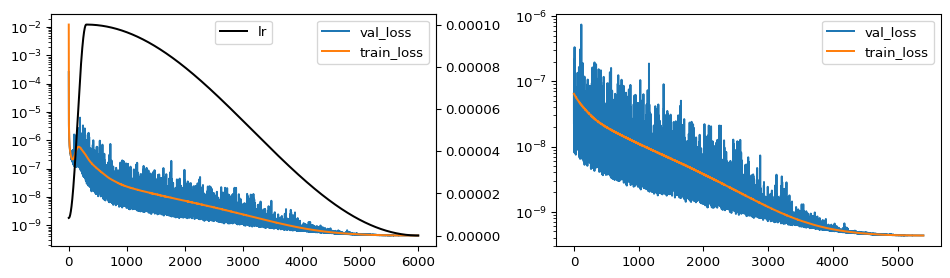

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [38]:
np.min(history['train_loss']), np.min(history['val_loss'])

(4.322738919615494e-10, 4.3340711725104426e-10)

# loaded model test, w jit, 

In [39]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [40]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [41]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 137.25297866389155 micro-sec


##### w JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [43]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 98.68865501135588 micro-sec


# validation

In [44]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [45]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [46]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [47]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

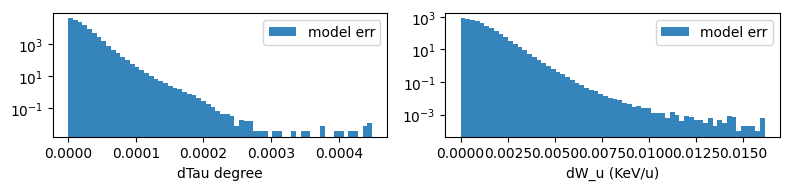

In [48]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)